# Import des modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import pearsonr

# Extrait SIRH

- Calcul des statistiques descriptives
- Objectif : faire ressortir des différences clés entre les employés

In [2]:
sirh = pd.read_csv('ExtraitSIRH.csv')
sirh.head(5)

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel
0,1,41,F,5993,CÃ©libataire,Commercial,Cadre Commercial,8,80,8,6,4
1,2,49,M,5130,MariÃ©(e),Consulting,Assistant de Direction,1,80,10,10,7
2,4,37,M,2090,CÃ©libataire,Consulting,Consultant,6,80,7,0,0
3,5,33,F,2909,MariÃ©(e),Consulting,Assistant de Direction,1,80,8,8,7
4,7,27,M,3468,MariÃ©(e),Consulting,Consultant,9,80,6,2,2


# Extrait SIRH - Graphiques

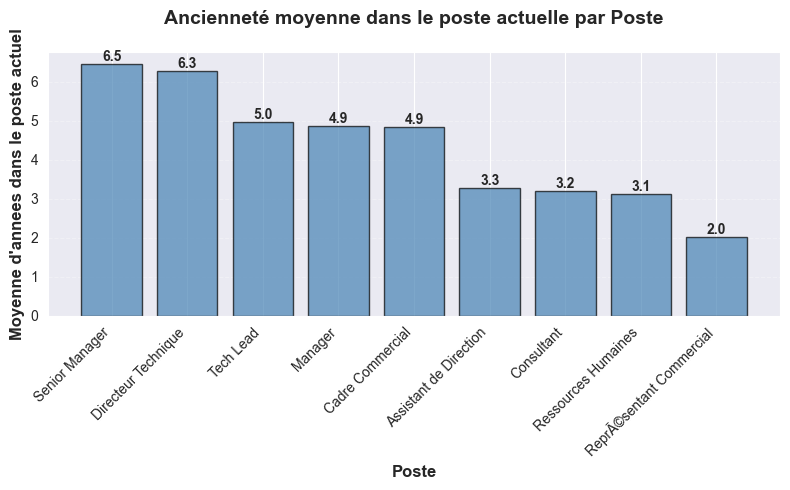

=== Statistiques du ratio de mutation interne ===

=== Interprétation ===
• Ratio proche de 100% : Employé n'a jamais changé de poste
• Ratio proche de 0 : Employé a changé de poste récemment
• Ratio faible = Forte mobilité interne
Ratio moyen: 59.61%
Ratio médian: 66.67%
Ratio min: 0.00%
Ratio max: 100.00%
1. Ancienneté moyenne des employés sans mobilité (ratio entre 0,8 et 1): 8.7 ans
2. Ancienneté moyenne des employés avec mobilité (ratio < 0,8): 7.5 ans
3. Corrélation entre ancienneté et ratio: 0.027
   (Plus proche de 0 = pas de lien, proche de 1 = lien positif)


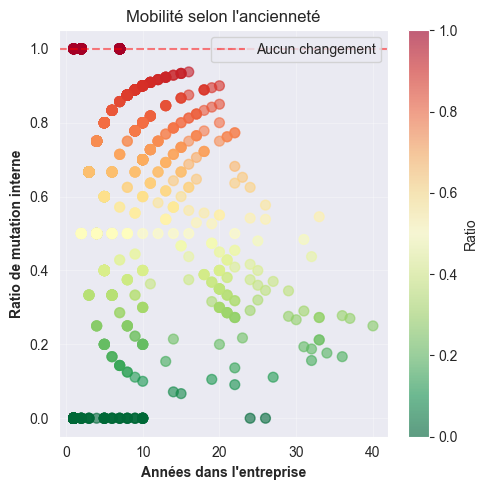

=== ANALYSE DE CORRÉLATION ===

Corrélation de Pearson: 0.514
Corrélation de Spearman: 0.464
Augmentation moyenne par année: 395€
Revenu de base estimé (0 ans): 3,733€


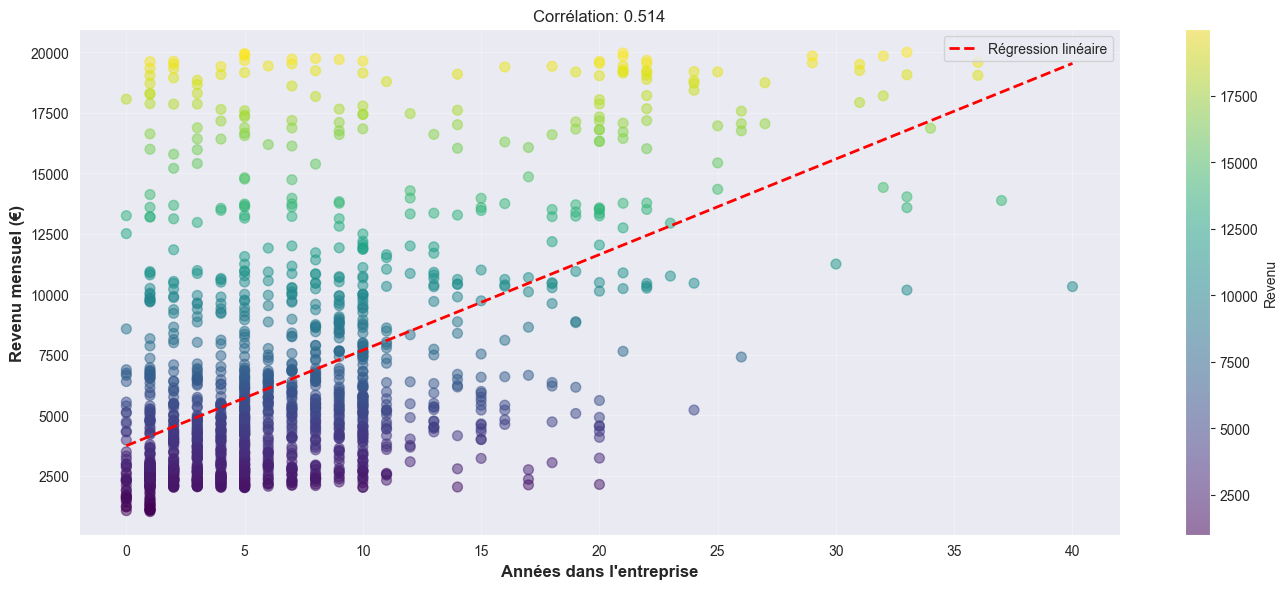

In [3]:
#------------------------
# Moyenne d'annees dans le poste actuel par poste
#------------------------

moyennes = sirh.groupby('poste')['annees_dans_le_poste_actuel'].mean()
# Trier par valeur décroissante (optionnel)
moyennes = moyennes.sort_values(ascending=False)

# Créer le graphique
plt.figure(figsize=(8, 5))
bars = plt.bar(moyennes.index, moyennes.values,
               color='steelblue', edgecolor='black', alpha=0.7)

# Personnalisation
plt.xlabel('Poste', fontsize=12, fontweight='bold')
plt.ylabel('Moyenne d\'annees dans le poste actuel', fontsize=12, fontweight='bold')
plt.title('Ancienneté moyenne dans le poste actuelle par Poste', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

#------------------------
# ratio de mutation interne
#------------------------

# Calculer le ratio de mutation interne
# Ratio = années dans le poste actuel / années dans l'entreprise
sirh['ratio_mutation_interne'] = sirh['annees_dans_le_poste_actuel'] / sirh['annees_dans_l_entreprise']
sirh['ratio_mutation_interne'] = sirh['ratio_mutation_interne'].replace([np.inf, -np.inf], np.nan)

# Afficher quelques statistiques
print("=== Statistiques du ratio de mutation interne ===")
print("\n=== Interprétation ===")
print("• Ratio proche de 100% : Employé n'a jamais changé de poste")
print("• Ratio proche de 0 : Employé a changé de poste récemment")
print("• Ratio faible = Forte mobilité interne")

print(f"Ratio moyen: {sirh['ratio_mutation_interne'].mean():.2%}")
print(f"Ratio médian: {sirh['ratio_mutation_interne'].median():.2%}")
print(f"Ratio min: {sirh['ratio_mutation_interne'].min():.2%}")
print(f"Ratio max: {sirh['ratio_mutation_interne'].max():.2%}")

print(f"1. Ancienneté moyenne des employés sans mobilité (ratio entre 0,8 et 1): "
      f"{sirh[(sirh['ratio_mutation_interne'] >= 0.8) & (sirh['ratio_mutation_interne'] < 1)]['annees_dans_l_entreprise'].mean():.1f} ans")
print(f"2. Ancienneté moyenne des employés avec mobilité (ratio < 0,8): "
      f"{sirh[sirh['ratio_mutation_interne'] < 0.8]['annees_dans_l_entreprise'].mean():.1f} ans")
print(f"3. Corrélation entre ancienneté et ratio: "
      f"{sirh['annees_dans_l_entreprise'].corr(sirh['ratio_mutation_interne']):.3f}")
print("   (Plus proche de 0 = pas de lien, proche de 1 = lien positif)")


# Créer une figure avec plusieurs sous-graphiques
plt.figure(figsize=(5, 5))

plt.scatter(sirh['annees_dans_l_entreprise'], sirh['ratio_mutation_interne'],
                     alpha=0.6, c=sirh['ratio_mutation_interne'], cmap='RdYlGn_r', s=50)
plt.xlabel('Années dans l\'entreprise', fontweight='bold')
plt.ylabel('Ratio de mutation interne', fontweight='bold')
plt.title('Mobilité selon l\'ancienneté')
plt.grid(alpha=0.3)
plt.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Aucun changement')
plt.colorbar(label='Ratio')
plt.legend()
plt.tight_layout()
plt.show()

################################################

# Calculer la corrélation
correlation = sirh['revenu_mensuel'].corr(sirh['annees_dans_l_entreprise'])
correlation_spearman = sirh['revenu_mensuel'].corr(sirh['annees_dans_l_entreprise'], method='spearman')

print("=== ANALYSE DE CORRÉLATION ===\n")
print(f"Corrélation de Pearson: {correlation:.3f}")
print(f"Corrélation de Spearman: {correlation_spearman:.3f}")

z = np.polyfit(sirh['annees_dans_l_entreprise'], sirh['revenu_mensuel'], 1)
print(f"Augmentation moyenne par année: {z[0]:,.0f}€")
print(f"Revenu de base estimé (0 ans): {z[1]:,.0f}€")

fig, axes = plt.subplots(figsize=(14, 6))
plt.scatter(sirh['annees_dans_l_entreprise'], sirh['revenu_mensuel'],
                     alpha=0.5, s=50, c=sirh['revenu_mensuel'], cmap='viridis')

# Ajouter la ligne de régression
z = np.polyfit(sirh['annees_dans_l_entreprise'], sirh['revenu_mensuel'], 1)
p = np.poly1d(z)
x_line = np.linspace(sirh['annees_dans_l_entreprise'].min(),
                     sirh['annees_dans_l_entreprise'].max(), 100)
plt.plot(x_line, p(x_line), "r--", linewidth=2, label=f'Régression linéaire')

plt.xlabel('Années dans l\'entreprise', fontweight='bold', fontsize=12)
plt.ylabel('Revenu mensuel (€)', fontweight='bold', fontsize=12)
plt.title(f'Corrélation: {correlation:.3f}', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.colorbar(label='Revenu')
plt.tight_layout()
plt.show()

sirh.drop((['ratio_mutation_interne']), axis=1, inplace=True)


=== MESURES DE DISPARITÉ PAR TRANCHE D'EXPÉRIENCE ===

                     min      q25   median      q75    max     mean     std  \
tranche_experience                                                            
0-5 ans             1009   2550.0   3782.0   5750.0  19943   5134.0  4024.0   
5-10 ans            2011   4048.0   5667.0   7980.0  19740   6567.0  3767.0   
10-15 ans           2028   4594.0   6268.0  10469.0  19094   7729.0  4078.0   
15-20 ans           2115   6014.0  10546.0  16121.0  19626  10930.0  5280.0   
20+ ans             5210  13622.0  17121.0  19190.0  19999  16008.0  3812.0   

                    count    cv  
tranche_experience               
0-5 ans               732  78.4  
5-10 ans              448  57.4  
10-15 ans             108  52.8  
15-20 ans              72  48.3  
20+ ans                66  23.8  

📊 Coefficient de Variation (CV) :
   • CV < 15% : Faible disparité
   • CV 15-30% : Disparité modérée
   • CV > 30% : Forte disparité


/var/folders/hm/xkkm6rp16357jgy5gn4qpdnw0000gn/T/ipykernel_19812/3835148215.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_par_tranche = sirh.groupby('tranche_experience')['revenu_mensuel'].agg([


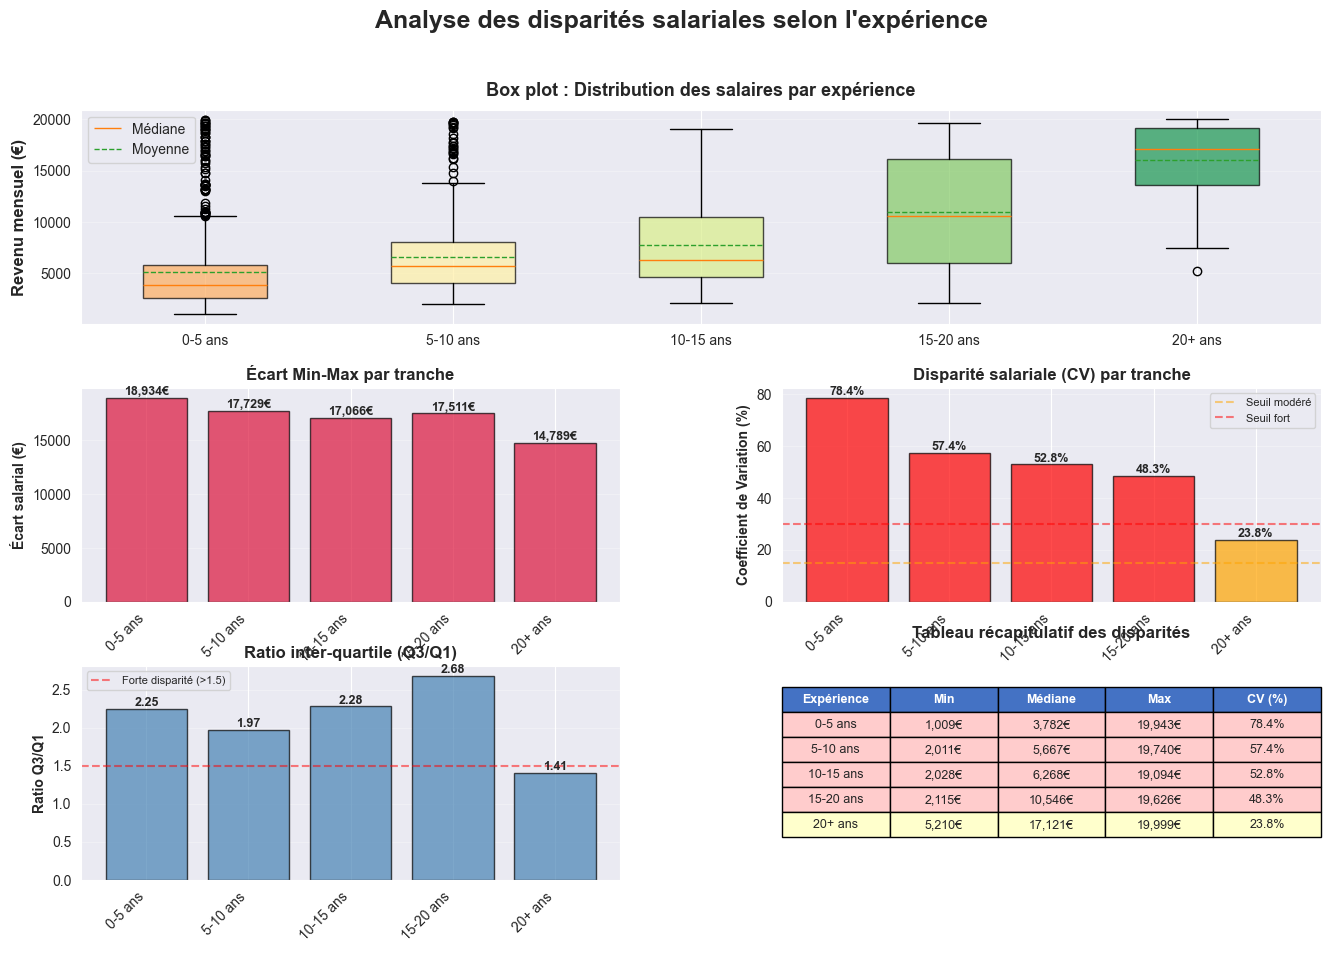


=== ANALYSE DÉTAILLÉE DES DISPARITÉS ===


📍 0-5 ans (732 employés)
   Salaire min: 1,009€
   Salaire max: 19,943€
   Écart: 18,934€
   Écart-type: 4,024€
   CV: 78.4%
   ⚠️ 69 salaire(s) exceptionnellement élevé(s)

📍 5-10 ans (448 employés)
   Salaire min: 2,011€
   Salaire max: 19,740€
   Écart: 17,729€
   Écart-type: 3,767€
   CV: 57.4%
   ⚠️ 25 salaire(s) exceptionnellement élevé(s)

📍 10-15 ans (108 employés)
   Salaire min: 2,028€
   Salaire max: 19,094€
   Écart: 17,066€
   Écart-type: 4,078€
   CV: 52.8%

📍 15-20 ans (72 employés)
   Salaire min: 2,115€
   Salaire max: 19,626€
   Écart: 17,511€
   Écart-type: 5,280€
   CV: 48.3%

📍 20+ ans (66 employés)
   Salaire min: 5,210€
   Salaire max: 19,999€
   Écart: 14,789€
   Écart-type: 3,812€
   CV: 23.8%
   ⚠️ 1 salaire(s) exceptionnellement faible(s)

=== CONCLUSION ===

🔴 Disparité maximale dans la tranche : 0-5 ans
   avec un CV de 78.4%


In [4]:
# Créer des tranches d'expérience
bins = [0, 5, 10, 15, 20, 100]
labels = ['0-5 ans', '5-10 ans', '10-15 ans', '15-20 ans', '20+ ans']
sirh['tranche_experience'] = pd.cut(sirh['annees_dans_l_entreprise'], bins=bins, labels=labels)

# Calculer les statistiques par tranche
stats_par_tranche = sirh.groupby('tranche_experience')['revenu_mensuel'].agg([
    ('min', 'min'),
    ('q25', lambda x: x.quantile(0.25)),
    ('median', 'median'),
    ('q75', lambda x: x.quantile(0.75)),
    ('max', 'max'),
    ('mean', 'mean'),
    ('std', 'std'),
    ('count', 'count')
]).round(0)

# Calculer le coefficient de variation (CV) pour mesurer la disparité
stats_par_tranche['cv'] = (stats_par_tranche['std'] / stats_par_tranche['mean'] * 100).round(1)

print("=== MESURES DE DISPARITÉ PAR TRANCHE D'EXPÉRIENCE ===\n")
print(stats_par_tranche)
print("\n📊 Coefficient de Variation (CV) :")
print("   • CV < 15% : Faible disparité")
print("   • CV 15-30% : Disparité modérée")
print("   • CV > 30% : Forte disparité")

# Créer une visualisation complète
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

fig.suptitle('Analyse des disparités salariales selon l\'expérience',
             fontsize=18, fontweight='bold', y=0.98)

# 1. Box plot pour montrer les disparités
ax1 = fig.add_subplot(gs[0, :])
bp = ax1.boxplot([sirh[sirh['tranche_experience'] == t]['revenu_mensuel'].dropna()
                   for t in labels],
                  tick_labels=labels,
                  patch_artist=True,
                  showmeans=True,
                  meanline=True)

# Colorier les boîtes
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(labels)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_ylabel('Revenu mensuel (€)', fontweight='bold', fontsize=12)
ax1.set_title('Box plot : Distribution des salaires par expérience',
              fontsize=13, fontweight='bold', pad=10)
ax1.grid(axis='y', alpha=0.3)
ax1.legend([bp['medians'][0], bp['means'][0]],
           ['Médiane', 'Moyenne'], loc='upper left')

# 2. Écart Min-Max par tranche
ax2 = fig.add_subplot(gs[1, 0])
ecarts = stats_par_tranche['max'] - stats_par_tranche['min']
bars = ax2.bar(range(len(ecarts)), ecarts, color='crimson', alpha=0.7, edgecolor='black')
ax2.set_xticks(range(len(labels)))
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.set_ylabel('Écart salarial (€)', fontweight='bold')
ax2.set_title('Écart Min-Max par tranche', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, ecarts)):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{val:,.0f}€',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Coefficient de variation
ax3 = fig.add_subplot(gs[1, 1])
colors_cv = ['green' if cv < 15 else 'orange' if cv < 30 else 'red'
             for cv in stats_par_tranche['cv']]
bars = ax3.bar(range(len(stats_par_tranche['cv'])), stats_par_tranche['cv'],
               color=colors_cv, alpha=0.7, edgecolor='black')
ax3.set_xticks(range(len(labels)))
ax3.set_xticklabels(labels, rotation=45, ha='right')
ax3.set_ylabel('Coefficient de Variation (%)', fontweight='bold')
ax3.set_title('Disparité salariale (CV) par tranche', fontweight='bold')
ax3.axhline(y=15, color='orange', linestyle='--', alpha=0.5, label='Seuil modéré')
ax3.axhline(y=30, color='red', linestyle='--', alpha=0.5, label='Seuil fort')
ax3.legend(fontsize=8)
ax3.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, stats_par_tranche['cv']):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{val:.1f}%',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 4. Ratio Q3/Q1 (mesure d'inégalité)
ax4 = fig.add_subplot(gs[2, 0])
ratio_q3q1 = (stats_par_tranche['q75'] / stats_par_tranche['q25']).round(2)
bars = ax4.bar(range(len(ratio_q3q1)), ratio_q3q1, color='steelblue',
               alpha=0.7, edgecolor='black')
ax4.set_xticks(range(len(labels)))
ax4.set_xticklabels(labels, rotation=45, ha='right')
ax4.set_ylabel('Ratio Q3/Q1', fontweight='bold')
ax4.set_title('Ratio inter-quartile (Q3/Q1)', fontweight='bold')
ax4.axhline(y=1.5, color='red', linestyle='--', alpha=0.5,
            label='Forte disparité (>1.5)')
ax4.legend(fontsize=8)
ax4.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, ratio_q3q1):
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{val:.2f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 5. Tableau récapitulatif
ax5 = fig.add_subplot(gs[2, 1])
ax5.axis('tight')
ax5.axis('off')

# Préparer les données pour le tableau
table_data = []
for idx, row in stats_par_tranche.iterrows():
    table_data.append([
        str(idx),
        f"{row['min']:,.0f}€",
        f"{row['median']:,.0f}€",
        f"{row['max']:,.0f}€",
        f"{row['cv']:.1f}%"
    ])

table = ax5.table(cellText=table_data,
                  colLabels=['Expérience', 'Min', 'Médiane', 'Max', 'CV (%)'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0.2, 1, 0.7])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Colorer l'en-tête
for i in range(5):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Colorer les lignes selon le CV
for i, row in enumerate(stats_par_tranche.iterrows(), start=1):
    cv = row[1]['cv']
    if cv > 30:
        color = '#ffcccc'  # Rouge clair
    elif cv > 15:
        color = '#ffffcc'  # Jaune clair
    else:
        color = '#ccffcc'  # Vert clair

    for j in range(5):
        table[(i, j)].set_facecolor(color)

ax5.set_title('Tableau récapitulatif des disparités', fontweight='bold', pad=20)

plt.savefig('images/disparites_salariales.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyse détaillée dans la console
print("\n=== ANALYSE DÉTAILLÉE DES DISPARITÉS ===\n")

for tranche in labels:
    data_tranche = sirh[sirh['tranche_experience'] == tranche]['revenu_mensuel']
    n = len(data_tranche)

    print(f"\n📍 {tranche} ({n} employés)")
    print(f"   Salaire min: {data_tranche.min():,.0f}€")
    print(f"   Salaire max: {data_tranche.max():,.0f}€")
    print(f"   Écart: {data_tranche.max() - data_tranche.min():,.0f}€")
    print(f"   Écart-type: {data_tranche.std():,.0f}€")
    print(f"   CV: {(data_tranche.std()/data_tranche.mean()*100):.1f}%")

    # Identifier les valeurs extrêmes
    q1 = data_tranche.quantile(0.25)
    q3 = data_tranche.quantile(0.75)
    iqr = q3 - q1
    outliers_low = data_tranche[data_tranche < q1 - 1.5*iqr]
    outliers_high = data_tranche[data_tranche > q3 + 1.5*iqr]

    if len(outliers_high) > 0:
        print(f"   ⚠️ {len(outliers_high)} salaire(s) exceptionnellement élevé(s)")
    if len(outliers_low) > 0:
        print(f"   ⚠️ {len(outliers_low)} salaire(s) exceptionnellement faible(s)")

print("\n=== CONCLUSION ===")
tranche_max_disparite = stats_par_tranche['cv'].idxmax()
print(f"\n🔴 Disparité maximale dans la tranche : {tranche_max_disparite}")
print(f"   avec un CV de {stats_par_tranche.loc[tranche_max_disparite, 'cv']:.1f}%")

sirh.drop((['tranche_experience']), axis=1, inplace=True)

# Extrait Evaluation Performance

- Calcul des statistiques descriptives
- Objectif : faire ressortir des différences clés entre les employés

In [5]:
eval_perf = pd.read_csv('ExtraitEvaluationsPerformance.csv')
eval_perf.head(5)

,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente
0,2,3,2,4,1,1,E_1,3,Oui,11 %
1,3,2,2,2,4,3,E_2,4,Non,23 %
2,4,2,1,3,2,3,E_4,3,Oui,15 %
3,4,3,1,3,3,3,E_5,3,Oui,11 %
4,1,3,1,2,4,3,E_7,3,Non,12 %


# Extrait Sondage

- Calcul des statistiques descriptives
- Objectif : faire ressortir des différences clés entre les employés

In [6]:
sondage = pd.read_csv('ExtraitSondage.csv')
sondage.head(5)

,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0
3,Non,0,3,1,5,3,4,Infra & Cloud,Y,Frequent,3,0
4,Non,1,3,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2


a_quitte_l_entreprise
Non    1233
Oui     237
Name: count, dtype: int64


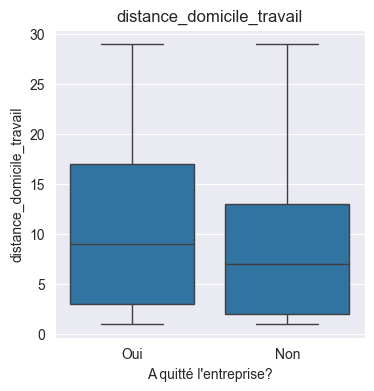

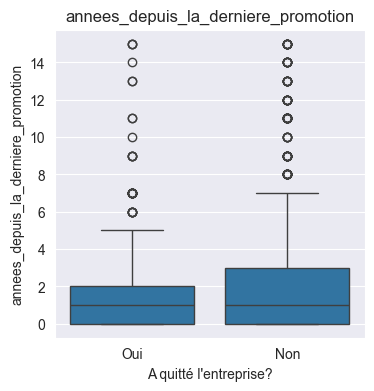

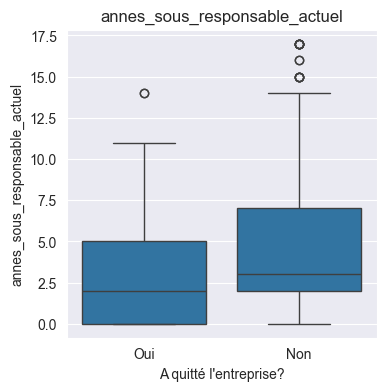

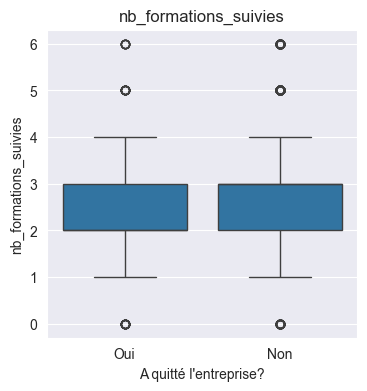

In [7]:
print(sondage['a_quitte_l_entreprise'].value_counts())

# Liste des colonnes à comparer
colonnes_a_comparer = ['distance_domicile_travail', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel', 'nb_formations_suivies']  # exemple

for col in colonnes_a_comparer:
    plt.figure(figsize=(4,4))
    sns.boxplot(x='a_quitte_l_entreprise', y=col, data=sondage)
    plt.xticks([0,1])
    plt.title(f"{col}")
    plt.ylabel(col)
    plt.xlabel("A quitté l'entreprise?")
    plt.show()


# Création du fichier central

- Identifier les colonnes permettant de réaliser des jointures entre les 3 fichiers :
    - ExtraitSIRH = id_employee
    - ExtraitEvaluationsPerformance = eval_number
    - ExtraitSondage = code_sondage


In [8]:
###########
# PANDAS
##########

# Modifier des donnes de la colonne "eval_number" de "eval_perf"
eval_perf['eval_number'] = eval_perf['eval_number'].str.replace('E_', '', regex=False).astype(int)
#print(eval_perf['eval_number'])

fc_temp = pd.merge(sirh, eval_perf, left_on="id_employee", right_on="eval_number")
fc = pd.merge(fc_temp, sondage, left_on="id_employee", right_on="code_sondage")
fc.head(5)

fc.drop((['eval_number','code_sondage']), axis=1, inplace=True)

##########
# SQL
##########


# Colonnes à traiter
- statut_marital, poste => remplacer les caracteres illisibles
- nombre_heures_travailles, nombre_employee_sous_responsabilite, ayant_enfants => A supprimer car données identiques

In [9]:
# Nom de colonne erronees
fc.rename(columns={'augementation_salaire_precedente': 'augmentation_salaire_precedente'}, inplace=True)
fc.rename(columns={'annee_experience_totale': 'annees_experience_totale'}, inplace=True)

# Données uniques
print(f"Colonnes avec des données uniques: {fc.columns[fc.nunique() == 1].tolist()}")
fc.drop((['nombre_heures_travailless','nombre_employee_sous_responsabilite','ayant_enfants']), axis=1, inplace=True)

# Données erronees
#print(fc.groupby(['statut_marital']).size().sort_values(ascending=False))
#print(fc.groupby(['poste']).size().sort_values(ascending=False))

for col in fc.select_dtypes(include='object').columns:
    fc[col] = fc[col].str.replace('Ã©', 'e', regex=False)

print(fc.groupby(['statut_marital']).size().sort_values(ascending=False))
print(fc.groupby(['poste']).size().sort_values(ascending=False))

# Données non valides
fc['augmentation_salaire_precedente'] = fc['augmentation_salaire_precedente'].str.replace(' %', '', regex=False).astype(int)

# Données redondantes
fc.drop((['departement']), axis=1, inplace=True)

# Satisfaction Globale
fc["satisfaction_globale"] = (fc["satisfaction_employee_environnement"]+fc["satisfaction_employee_nature_travail"]+fc["satisfaction_employee_equipe"]+fc["satisfaction_employee_equilibre_pro_perso"])*100/16


Colonnes avec des données uniques: ['nombre_heures_travailless', 'nombre_employee_sous_responsabilite', 'ayant_enfants']
statut_marital
Marie(e)       673
Celibataire    470
Divorce(e)     327
dtype: int64
poste
Cadre Commercial           326
Assistant de Direction     292
Consultant                 259
Tech Lead                  145
Manager                    131
Senior Manager             102
Representant Commercial     83
Directeur Technique         80
Ressources Humaines         52
dtype: int64


# Comparaison des colonnes
- Identifier le profil type d'un salarié qui a démissioné

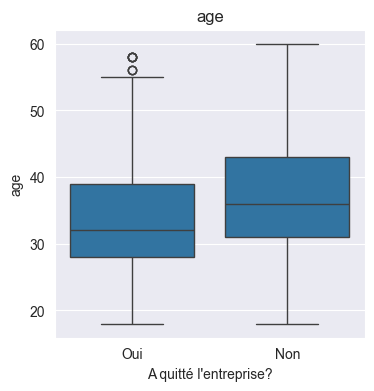

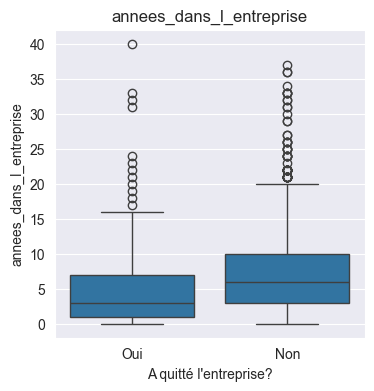

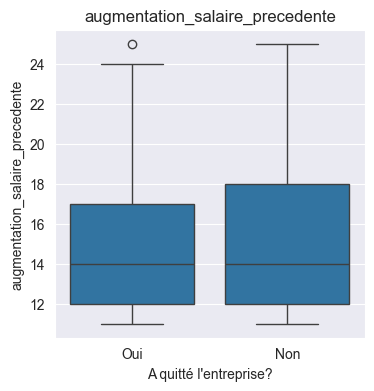

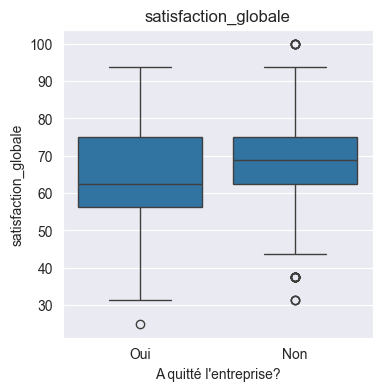

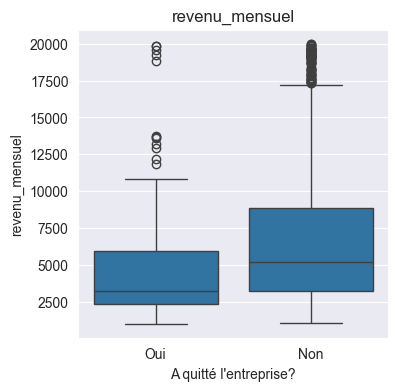

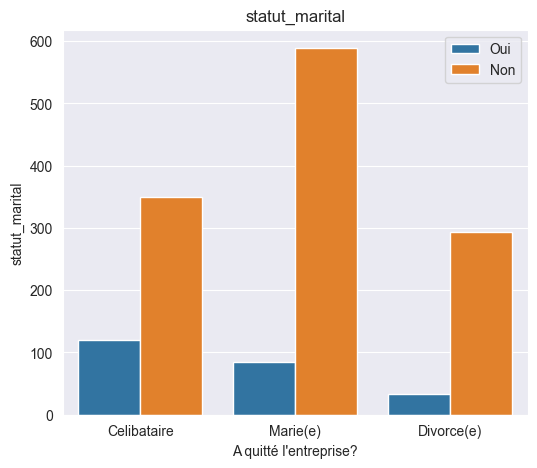

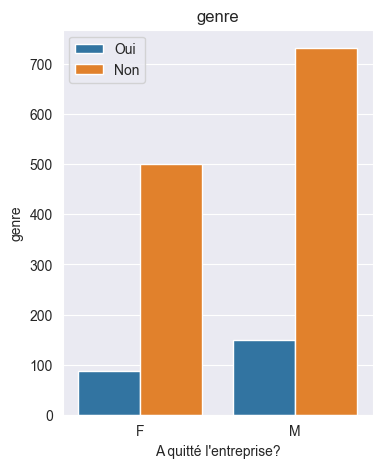

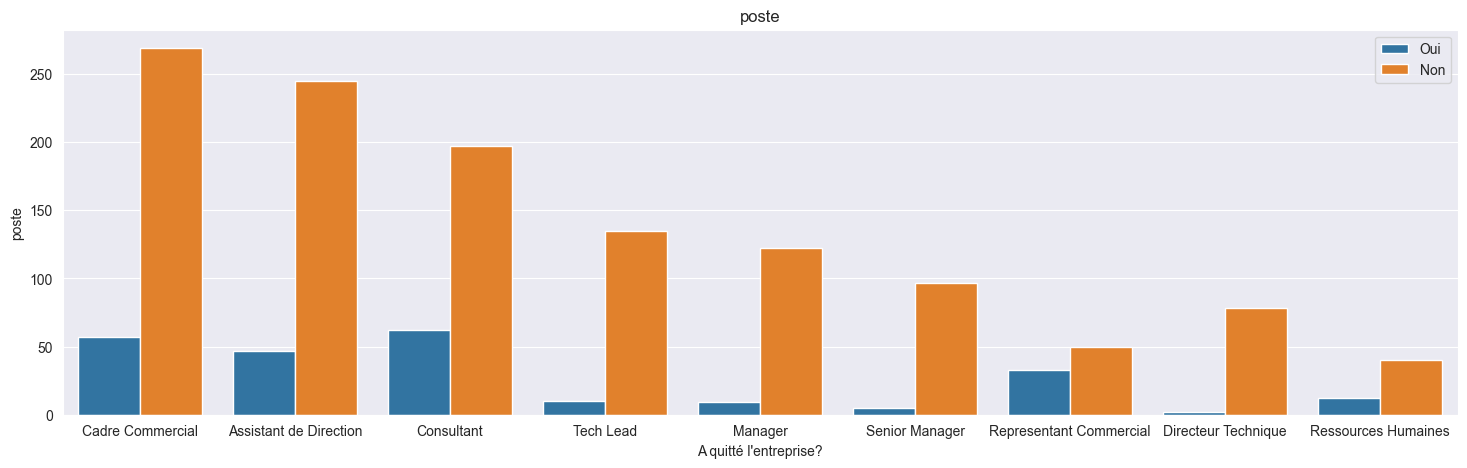

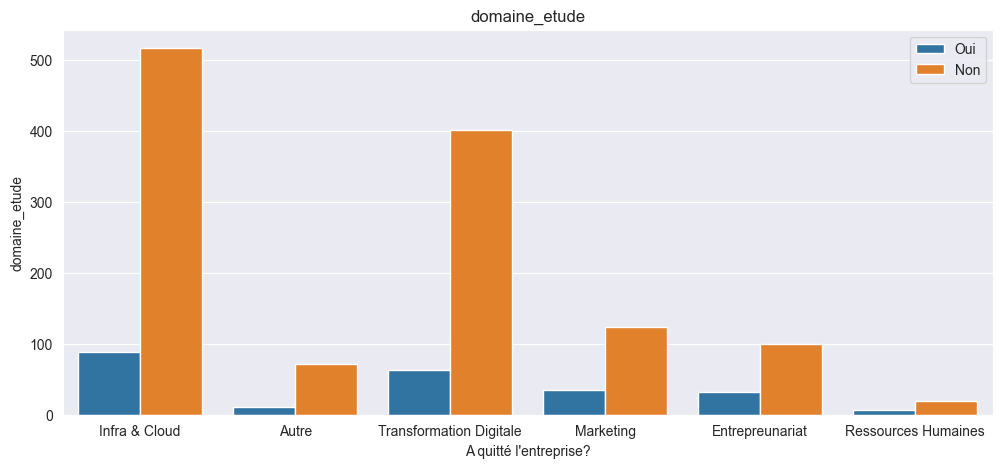

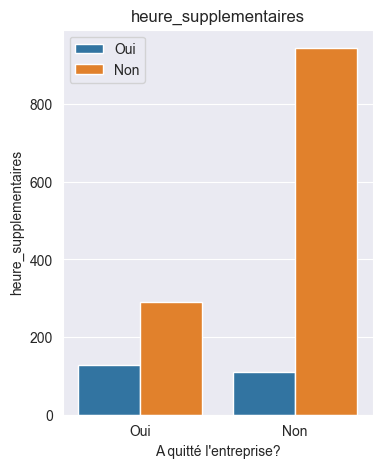

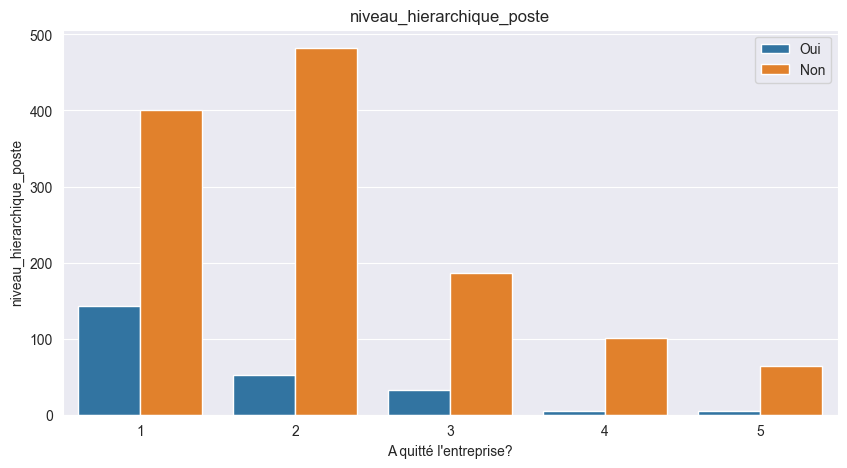

In [10]:
# Liste des colonnes à comparer
colonnes_a_comparer = ['age', 'annees_dans_l_entreprise', 'augmentation_salaire_precedente','satisfaction_globale','revenu_mensuel']  # exemple

# Création des boxplots
for col in colonnes_a_comparer:
    plt.figure(figsize=(4,4))
    sns.boxplot(x='a_quitte_l_entreprise', y=col, data=fc)
    plt.xticks([0,1])
    plt.title(f"{col}")
    plt.ylabel(col)
    plt.xlabel("A quitté l'entreprise?")
    plt.show()

colonnes_a_comparer = ['statut_marital','genre','poste','domaine_etude','heure_supplementaires', 'niveau_hierarchique_poste' ]

for col in colonnes_a_comparer:
    nb_categories = fc[col].nunique()
    plt.figure(figsize=(nb_categories*2, 5))
    sns.countplot(x=col, hue='a_quitte_l_entreprise', data=fc)
    plt.xlabel("A quitté l'entreprise?")
    plt.ylabel(f"{col}")
    plt.title(f"{col}")
    plt.legend()
    plt.show()


#

# Export CSV

In [11]:
fc.to_csv('fc.csv', index=False)